In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, QuantileTransformer, MinMaxScaler

from umap import UMAP
from sklearn.cluster import DBSCAN
import time
from tensorflow.keras.losses import CategoricalCrossentropy

# Add labels to meta data

In [14]:
labels_raw = [np.load('./labels/'+x) for x in os.listdir('./labels/') if x.endswith('.npy')]

label_dict = {}
value_array = []
for values in labels_raw:
    for value,ind in zip(values[0],values[1]):
        value_array.append(value)
        #print(value)
        label_dict[value] = ind

meta_data = pd.read_csv('cluster_meta.csv')
file_index = meta_data['cluster'].values

label_list = [label_dict[int(x[:-2])] for x in file_index]

meta_data.insert(6,'label',label_list)

meta_data = meta_data.drop(meta_data[meta_data['label'] == 4].index)
meta_data = meta_data.drop(meta_data[meta_data['label'] == 0].index)
meta_data['label'] = meta_data['label'] - 1



meta_data = meta_data.to_csv('cluster_meta_labels.csv', index = False)

# Import Data

In [15]:


meta_data = pd.read_csv('cluster_meta_labels.csv')
print(meta_data.head())

def load_data_with_label(folder_path, meta_data):
    data = []
    for file in meta_data['cluster']:
        file = file + '.csv'
        file_path = os.path.join(folder_path,file)
        cluster = pd.read_csv(file_path,header=None).values
        cluster = cluster.flatten()
        # cluster = np.append(cluster, meta_data[meta_data['cluster'] == file[:-4]][['y', 'x', 'E', 'size']].values.flatten())
        data.append(cluster)
    combined_array = np.stack(data,axis=0)
    print('shape of combined array: ')
    print(combined_array.shape)
    return combined_array, meta_data[['y', 'x', 'E', 'size']].values, meta_data['label'].values




meta_scaler = RobustScaler()
meta_data_values = meta_scaler.fit_transform(meta_data[['y', 'x', 'E', 'size']])



   Unnamed: 0   cluster     y     x          E   size  label
0           0  004580_A   9.0  26.0   715232.0  108.0      2
1           2  003882_A   3.0   3.0    31156.0    6.0      0
2           3  009717_G   7.0  62.0  1423016.0  245.0      2
3           4  005590_A  32.0  31.0  1014772.0  169.0      2
4           5  008859_G  13.0   9.0   397825.0   63.0      2


In [16]:
class NumpyArrayDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample  # Return only the sample and dummy label





folder_path = 'clusters_colour_rotations_rescaled'
combined_array, meta_data_values, meta_data_labels = load_data_with_label(folder_path, meta_data)

meta_data_labels = meta_data_labels.astype(int)







shape of combined array: 
(3112, 4096)


# Normelize Data

In [17]:
scaler = MinMaxScaler()
combined_array_scaled = scaler.fit_transform(np.log(combined_array))
print(combined_array.shape)

meta_scaler = QuantileTransformer()
meta_data_values = meta_scaler.fit_transform(meta_data_values)

combined_array_scaled = np.append(combined_array_scaled, meta_data_values, axis=1)

combined_array_scaled = np.append(combined_array_scaled, meta_data_labels[:,None], axis=1)
#print(combined_array_scaled.T[-5:])

transform = transforms.Compose([
    transforms.ToTensor()
])

np.random.shuffle(combined_array_scaled)

#meta_data_values = NumpyArrayDataset(meta_data_values, transform=transform)
dataset = NumpyArrayDataset(combined_array_scaled, transform=transform)
print(combined_array_scaled.shape)

# lazy, non-random split
test_size = 0.2
split_index = int(len(dataset) * (1 - test_size))
train_dataset = dataset[:split_index]
test_dataset = dataset[split_index:]
#train_meta = meta_data_values[:split_index]
#test_meta = meta_data_values[split_index:]
#train_labels = meta_data_labels[:split_index]
#test_labels = meta_data_labels[split_index:]


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(train_loader.dataset[0].shape)




(3112, 4096)
(3112, 4101)
torch.Size([2489, 4101])


# Chosse device

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cpu')

# Create Model

In [19]:



def create_torch_model_CNN_HPO(trial):
    N_conv_layers = trial.suggest_int('N_conv_layers', 1, 3)
    N_dense_layers = trial.suggest_int('N_dense_layers', 1, 3)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    num_classes = 3
    class torch_CNN_HPO(nn.Module):
        def __init__(self):
            super().__init__()


            ### Flattening:
            self.flatten = nn.Flatten(start_dim=0)

            self.peram_to_optimize = []
            ### dropout
            self.dropout = nn.Dropout(dropout_rate, inplace=True)

            self.compile_model()
        
        def create_CNN_layer(self, size_in, filters_in, layer_number):
            filters_out = trial.suggest_int('filters_layer'+str(layer_number), 8, 64)
            filter_size = trial.suggest_int('filter_size_layer'+str(layer_number), 3, 7)
            stride_cnn = trial.suggest_int('stride_layer'+str(layer_number), 1, 3)
            padding = trial.suggest_int('padding_layer'+str(layer_number), 1, 3)
            pool_size = 3
            pool_stride = 1
            pool_padding = 1
            cnn_layer = nn.Sequential(
                nn.Conv2d(filters_in, filters_out, filter_size, stride=stride_cnn, padding=padding),  # 1x256x256 -> 32x128x128
                nn.ReLU(True),
                nn.MaxPool2d(pool_size, stride=pool_stride, padding=pool_padding)  # 64x64x64 -> 64x32x32
            ).to(device)
            size_out = (size_in - filter_size + 2*padding) // stride_cnn + 1
            return cnn_layer, filters_out, size_out
        
        def create_liniar_layer(self, input_size, layer_number):
            output_size = trial.suggest_int('dense_layer'+str(layer_number), 8, 128)
            liniar_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(True)
            ).to(device)
            return liniar_layer, output_size
        
        def create_output_layer(self, input_size, output_size):
            output_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU()
            ).to(device)
            return output_layer
        
        def compile_model(self):
            #print('Model compiled')
            model_layers_cnn = []
            model_layers_dense = []
            size_in = 64
            for i in range(N_conv_layers):
                if i == 0:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_in, 1, i)
                else:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_out, filters_out, i)
                self.peram_to_optimize.append({'params': cnn_layer.parameters()})
                model_layers_cnn.append(cnn_layer)

            output_size = size_out ** 2 * filters_out
            for i in range(N_dense_layers):
                if i == 0:
                    liniar_layer, output_size = self.create_liniar_layer(output_size, i)
                else:
                    liniar_layer, output_size = self.create_liniar_layer(output_size, i)
                self.peram_to_optimize.append({'params': liniar_layer.parameters()})
                model_layers_dense.append(liniar_layer)
            
            output_layer = self.create_output_layer(output_size + 4, num_classes)
            self.peram_to_optimize.append({'params': output_layer.parameters()})
        
    
            
            def model_compiled_v2(x, meta):
                for layer in model_layers_cnn:
                    x = layer(x)
                #print(x.shape)
                x = self.flatten(x)
                x = self.dropout(x)
                for layer in model_layers_dense:
                    x = layer(x)
                y = torch.cat((x, meta), dim=0)
                x = output_layer(y)
                return x
            self.model_compiled = model_compiled_v2


        def forward(self, x):
            
            meta = x[-5:-1]
            label = x[-1]
            x = x[:-5].unflatten(0, (1, 1, 64, 64))

            x = self.model_compiled(x, meta)
            #print(label.type(), x.type())
            return x, label#.type(torch.cuda.ByteTensor)
    return torch_CNN_HPO().to(device)




def create_torch_model_CNN():
    N_conv_layers = 1
    N_dense_layers = 1
    dropout_rate = 0.4
    num_classes = 3
    
    

    class torch_CNN(nn.Module):
        def __init__(self):
            super().__init__()


            ### Flattening:
            self.flatten = nn.Flatten(start_dim=0)
            self.peram_to_optimize = []

            ### dropout
            self.dropout = nn.Dropout(dropout_rate, inplace=True)

            self.compile_model()

        
        def create_CNN_layer(self, size_in, filters_in):
            filters_out = 8
            filter_size = 3
            stride_cnn = 1
            padding = 1
            pool_size = 3
            pool_stride = 1
            pool_padding = 1
            cnn_layer = nn.Sequential(
                nn.Conv2d(filters_in, filters_out, filter_size, stride=stride_cnn, padding=padding),  # 1x256x256 -> 32x128x128
                nn.ReLU(True),
                nn.MaxPool2d(pool_size, stride=pool_stride, padding=pool_padding)  # 64x64x64 -> 64x32x32
            ).to(device)
            size_out = (size_in - filter_size + 2*padding) // stride_cnn + 1
            return cnn_layer, filters_out, size_out
        
        def create_liniar_layer(self, input_size):
            output_size = 32
            liniar_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU(True)
            ).to(device)
            return liniar_layer, output_size
        
        def create_output_layer(self, input_size, output_size):
            output_layer = nn.Sequential(
                nn.Linear(input_size, output_size),
                nn.ReLU()
            ).to(device)
            return output_layer
        
        
        
        def compile_model(self):
            model_layers_cnn = []
            model_layers_dense = []
            size_in = 32
            for i in range(N_conv_layers):
                if i == 0:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_in, 1)
                else:
                    cnn_layer, filters_out, size_out = self.create_CNN_layer(size_out, filters_out)

                self.peram_to_optimize.append({'params': cnn_layer.parameters()})
                model_layers_cnn.append(cnn_layer)

            #output_size = size_out ** 2 * filters_out
            output_size = filters_out
            for i in range(N_dense_layers):
                if i == 0:
                    liniar_layer, output_size = self.create_liniar_layer(output_size)
                else:
                    liniar_layer, output_size = self.create_liniar_layer(output_size)
                self.peram_to_optimize.append({'params': liniar_layer.parameters()})
                model_layers_dense.append(liniar_layer)
            
            output_layer = self.create_output_layer(output_size + 4, num_classes)
            self.peram_to_optimize.append({'params': output_layer.parameters()})
            
            
            def model_compiled_v2(x, meta):
                for layer in model_layers_cnn:
                    x = layer(x)
                   
                #print(x.shape)
                x = torch.mean(x, dim=3)
                #print(x.shape)
                x = torch.mean(x, dim=2)
                #print(x.shape)
                x = self.flatten(x)
                x = self.dropout(x)
                for layer in model_layers_dense:
                    x = layer(x)
                    
                y = torch.cat((x, meta), dim=0)
                x = output_layer(y)
                
                return x
            self.model_compiled = model_compiled_v2


        def forward(self, x):
            
            meta = x[-5:-1]
            label = x[-1]
            x = x[:-5].unflatten(0, (1, 1, 64, 64))

            x = self.model_compiled(x, meta)
            return x, label#.type(torch.cuda.ByteTensor)
    return torch_CNN().to(device)




def objective(trial, dataset_train, dataset_val, num_epochs=30):
    # Build model and optimizer.
    model = create_torch_model_CNN_HPO(trial)
    learning_rate = trial.suggest_float("adam_learning_rate", 1e-7, 1e-1, log=True)
    torch.manual_seed(42)
    peram_to_optimize = model.peram_to_optimize
    
    
    optimizer = optim.Adam(peram_to_optimize, lr=learning_rate)
    
    model.train()
    # Fit the model to the data
    train_losses, valid_losses, train_accuracy, valid_accuracy = train_model(model, num_epochs, dataset_train, dataset_val, optimizer, loss_function)
    #model.fit(x=X_train, y = Y_train, epochs=30, validation_data=(X_test, Y_test), verbose=0)
    # Find the accuracy
    #cce = CategoricalCrossentropy()
    #accuracy = cce(Y_test, model(X_test))
    #Return accuracy
    return valid_losses[-1]





def loss_function(output, target):
    try:
        target = target.type(torch.cuda.ByteTensor)
    except:
        target = target.type(torch.ByteTensor)
    #plt.plot(target.cpu().detach().numpy())
    #plt.show()
    #print(output, target)
    #loss = F.cross_entropy(output, target)
    

    #cce = CategoricalCrossentropy()
    #loss = cce(y_true, output.detach().numpy())

    loss = nn.CrossEntropyLoss(reduction='sum')(output, target)
    return loss





def train_epoch(dataset_train, model, optimizer, loss_function):
    running_loss = 0
    accuracy = 0
    
    for batch in dataset_train:
        optimizer.zero_grad()
        #print(next(model.parameters()).device, batch, model.device)
        output, label_train = model(batch)
        #print(label_train, output)
        loss = loss_function(output, label_train)
        loss.backward()
        optimizer.step()
        #print(loss.item())
        running_loss += loss.item()
        #output_detached = output.detach().numpy()
        #label_train_detached = label_train.detach().numpy()
        accuracy += 1#np.argmax(output_detached) == int(label_train_detached)#cce(label_train, output)
    return running_loss / len(dataset_train), accuracy / len(dataset_train)

def validate_epoch(dataset_val, model, loss_function):
    running_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch in dataset_val:
            output, label_val = model(batch)
            loss = loss_function(output, label_val)
            running_loss += loss.item()
            #output_detached = output.detach().numpy()
            #label_val_detached = label_val.detach().numpy()
            accuracy += 1#np.argmax(output_detached) == int(label_val_detached)#cce(label_val, output)

    return running_loss / len(dataset_val), accuracy / len(dataset_val)

def train_model(model, num_epochs, dataset_train, dataset_val, optimizer, loss_function):
    

    train_losses = []
    train_accuracys = []
    valid_losses = []
    validate_accuracys = []

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_accuracy = train_epoch(dataset_train, model, optimizer, loss_function)
        valid_loss, validate_accuracy = validate_epoch(dataset_val, model, loss_function)
        train_losses.append(train_loss)
        train_accuracys.append(train_accuracy)
        valid_losses.append(valid_loss)
        validate_accuracys.append(validate_accuracy)
        end_time = time.time()
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train Accuracy: {train_accuracy}, Valid Accuracy: {validate_accuracy}, Duration: {end_time - start_time:.2f} sec")
    return train_losses, valid_losses, train_accuracys, validate_accuracys

def plot_losses(train_losses, valid_losses, train_accuracys, validate_accuracys):
    fig, ax = plt.subplots(nrows=2, sharex=True)
    ax[0].plot(train_losses, label='Train Loss')
    ax[0].plot(valid_losses, label='Valid Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_yscale('log')
    ax[1].plot(train_accuracys, label='Train Accuracy')
    ax[1].plot(validate_accuracys, label='Valid Accuracy')
    ax[1].set_ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
a = np.array([1., 0, 0])
b = 1
a = torch.tensor(a)
b = torch.tensor(b)
print(loss_function(a,b))

tensor(1.5514, dtype=torch.float64)


# Load data to gpu

In [20]:
dataset_train = train_loader.dataset[0]
dataset_train = dataset_train.to(device)
dataset_val = valid_loader.dataset[0]
dataset_val = dataset_val.to(device)

# Normal Training

In [10]:
num_epochs = 30
model = create_torch_model_CNN()

learning_rate = 0.001
torch.manual_seed(42)

#print(peram_to_optimize)
peram_to_optimize = model.peram_to_optimize


optimizer = optim.Adam(peram_to_optimize, lr=learning_rate)
model.train()

train_losses, valid_losses, train_accuracys, validate_accuracys = train_model(model, num_epochs, dataset_train, dataset_val, optimizer, loss_function)

Epoch: 1/30, Train Loss: 0.8804, Valid Loss: 0.6413, Duration: 11.45 sec
Epoch: 2/30, Train Loss: 0.6006, Valid Loss: 0.5429, Duration: 11.34 sec
Epoch: 3/30, Train Loss: 0.5604, Valid Loss: 0.5159, Duration: 12.16 sec
Epoch: 4/30, Train Loss: 0.5361, Valid Loss: 0.5056, Duration: 11.77 sec
Epoch: 5/30, Train Loss: 0.5216, Valid Loss: 0.5113, Duration: 12.49 sec
Epoch: 6/30, Train Loss: 0.5168, Valid Loss: 0.4921, Duration: 11.44 sec
Epoch: 7/30, Train Loss: 0.5136, Valid Loss: 0.4945, Duration: 11.85 sec
Epoch: 8/30, Train Loss: 0.5086, Valid Loss: 0.4831, Duration: 12.50 sec
Epoch: 9/30, Train Loss: 0.5040, Valid Loss: 0.4881, Duration: 12.21 sec
Epoch: 10/30, Train Loss: 0.4974, Valid Loss: 0.4926, Duration: 12.05 sec
Epoch: 11/30, Train Loss: 0.5014, Valid Loss: 0.4793, Duration: 11.42 sec
Epoch: 12/30, Train Loss: 0.4998, Valid Loss: 0.4709, Duration: 11.31 sec
Epoch: 13/30, Train Loss: 0.4982, Valid Loss: 0.4749, Duration: 11.38 sec
Epoch: 14/30, Train Loss: 0.4935, Valid Loss: 0

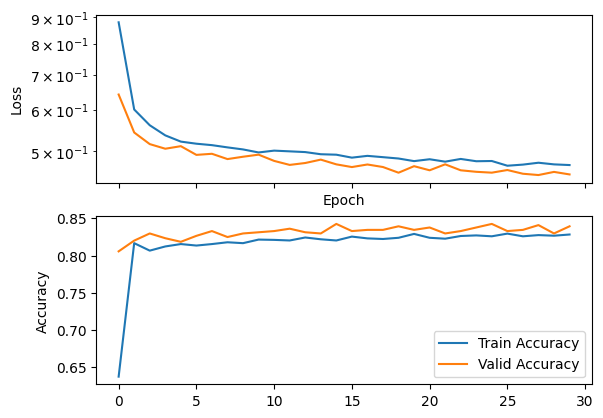

In [11]:
plot_losses(train_losses, valid_losses, train_accuracys, validate_accuracys)

# HPO

In [21]:
import optuna
num_epochs = 10
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, dataset_train, dataset_val, num_epochs), n_trials=30)




[I 2024-06-10 16:41:31,857] A new study created in memory with name: no-name-3c243ae8-efb7-4a33-bbae-0ac9f6607adb
[W 2024-06-10 16:43:35,286] Trial 0 failed with parameters: {'N_conv_layers': 2, 'N_dense_layers': 2, 'dropout_rate': 0.1962080324308098, 'filters_layer0': 44, 'filter_size_layer0': 4, 'stride_layer0': 1, 'padding_layer0': 1, 'filters_layer1': 39, 'filter_size_layer1': 7, 'stride_layer1': 1, 'padding_layer1': 2, 'dense_layer0': 127, 'dense_layer1': 39, 'adam_learning_rate': 0.01494901997245282} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/sk0rt3/anaconda3/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_9417/2604080421.py", line 4, in <lambda>
    study.optimize(lambda trial: objective(trial, dataset_train, dataset_val, num_epochs), n_trials=30)
                                 ^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [ ]:
print(42*19*19)

15162


# Run model

In [ ]:
def test_func(model, dataset):
    output = np.zeros(len(dataset))
    label = np.zeros(len(dataset))
    for batch in dataset:
        model(batch)
        
for i in range(10):
    test_func(model, dataset_train)

/home/sk0rt3/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
print()

# CPU test

# Train model

In [ ]:
model = create_torch_model_CNN(3).to(device)
model = model.to(device)


dataset_train = train_loader.dataset[0]
dataset_val = valid_loader.dataset[0]


dataset_train = dataset_train.to(device)
dataset_val = dataset_val.to(device)

learning_rate = 0.001
torch.manual_seed(42)
peram_to_optimize = model.parameters()



optimizer = optim.Adam(peram_to_optimize, lr=learning_rate)

model = model.to(device)

model.train()

num_epochs = 10



print(next(model.parameters()).device, dataset_train.is_cuda)


train_losses, valid_losses = train_model(model, num_epochs, dataset_train, dataset_val, optimizer, loss_function)

plot_losses(train_losses, valid_losses)


cpu False
torch.cuda.ByteTensor torch.FloatTensor


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument target in method wrapper_CUDA_nll_loss_forward)